In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
# filename = raw_input("enter file name: ")

In [2]:
data=pd.read_csv('../input_data/train.csv')
# print data
# test=pd.read_csv('../input_data/sample_test.csv')
train=data.sample(frac=0.8,random_state=200)
validate=data.drop(train.index)
# train,validate=np.split(data,[int(.8*len(data))])

In [3]:
numerical=pd.DataFrame(train,columns=['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','left'])
categorical=pd.DataFrame(train,columns=['Work_accident','left','promotion_last_5years','sales','salary'])

In [4]:
def calculate_entropy(train):
    values=train.left.unique()
    entropy_node=0
    for v in values:
        num=train.left.value_counts()[v]
        deno=len(train.left)
        fraction=float(num)/deno
        if fraction!=0:
            entropy_node+=-(fraction*np.log2(fraction))
    return entropy_node

In [5]:
def entropy_attribute(df,attribute,original):
    variables=df[attribute].unique()
    values=df[original].unique()
    entropy_attribute=0
    I=0
    for v in variables:
        entropy_attribute=0
        n=df[attribute].value_counts()[v]
        d=len(df[attribute])
        for x in values:
            num=len(df[attribute][df[attribute]==v][df[original]==x])
            deno=len(df[attribute][df[attribute]==v])
            fraction=float(num)/deno
            if fraction!=0:
                entropy_attribute+=-(fraction*np.log2(fraction))
        I+=(float(n)/d)*entropy_attribute
    return I

In [6]:
def find_node(df,column):
    m=-sys.maxint-1
    value=0
    g=0
    df2=df
    c=''
#     for column in df:
    if column!='left':
        values=df2[column].unique()
        for i in values:
            rows1=df2[df2[column]<=i]
            rows2=df2[df2[column]>i]
            ent1=calculate_entropy(rows1)
            ent2=calculate_entropy(rows2)
            size1=len(rows1)
            size2=len(rows2)
            sizeall=len(df2)
            ent=(ent1*(size1/sizeall))+(ent2*(size2/sizeall))
            ent_total=calculate_entropy(df2)
            gain=ent_total-ent
            if m<gain:
                m=gain
                value=i
                c=column
    return m,value,c

In [7]:
# print find_node(train)
def max_gain(df):
    p=""
    m=-sys.maxint-1
    split_pt=None
    for i in df.columns:
        gain=0
        if i in numerical:
            if i!='left':
                gain,value,col=find_node(df,i)
                if m<gain:
                    m=gain
                    p=i
                    split_pt=value
        if i in categorical:
            if i!='left':
                gain=calculate_entropy(df)-entropy_attribute(df,i,'left')
                if m < gain:
                    m=gain
                    p=i
    return m,p,split_pt

In [8]:
class decisionTree():
    def __init__(self,name,df):
        self.label=name
        self.child={}
        self.positive=len(df[name][df['left']==1])
        self.negative=len(df[name][df['left']==0])
        self.isLeaf=False
    def set_child(self,ch):
        self.child=ch

In [9]:
def buildTree(df):
#     print "calling"
    if len(df.columns)<=1:
        leaf=decisionTree('left',df)
        leaf.isLeaf=True
        return leaf
    gain,label,value=max_gain(df)
#     print gain,value,label
    if gain<=0:
        leaf=decisionTree('left',df)
        leaf.isLeaf=True
        return leaf
    if label in numerical:
        root=decisionTree(label,df)
        df2=df
        children={}
        i=value
        rows1=df2[df2[label]<=i]
#         rows1=rows1.drop(columns=[label])
        rows2=df2[df2[label]>i]
#         rows2=rows2.drop(columns=[label])
        if rows1.size==df.size or rows2.size==df.size:
            leaf=decisionTree('left',df)
            leaf.isLeaf=True
            return leaf
        ch_root1=buildTree(rows1)
        key1=i
        key2=1
        children[key1]=ch_root1
        ch_root2=buildTree(rows2)
        children[key2]=ch_root2
        root.set_child(children)
    else:
        root=decisionTree(label,df)
#     print root.lable, root.positive, root.negative
        childs=df[label].unique()
        children={}
        df2=df
        for i in childs:
            rows=df2[df2[label]==i]
            rows=rows.drop(columns=[label])
            ch_root=buildTree(rows)
            children[i]=ch_root
        root.set_child(children)
        
    return root

In [10]:
root=buildTree(train)

In [11]:
def depth(root):
    if root.isLeaf==True:
        return 1
    max_depth=0
    if root==None:
        return 0
    if root.child=={}:
        return 1
    for i in root.child.keys():
        temp=depth(root.child[i])
        if temp+1>max_depth:
            max_depth=temp+1
    return max_depth

In [12]:
depth_of_tree=depth(root)
print depth_of_tree

17


In [13]:
def predict(model,model_args,X):
    root=model
    row=X
    depth=model_args
    if depth==0:
        if root.positive>root.negative:
            return "YES"
        else:
            return "NO"
    if root.isLeaf==True:
        if root.positive>root.negative:
            return "YES"
        else:
            return "NO"
    row1=row
    ch_node=None
#     print root.label,row1[root.label]
    if root.label in numerical:
        keys=root.child.keys()
        x=0
        for a in keys:
            if a!=1:
                x=a
        takeside=0
        if row1[root.label]>x:
            takeside=1
        else:
            takeside=x
        ch_node=root.child[takeside]
    else:
        if row1[root.label] in root.child.keys():
            ch_node=root.child[row1[root.label]]
            if ch_node!=None:
                if ch_node.label=='left':
                    if ch_node.positive>ch_node.negative:
                        return "YES"
                    else:
                        return "NO"
    if ch_node==None:
        if root.positive>root.negative:
            return "YES"
        else:
            return "NO"
    if ch_node!=None:
        depth-=1
        return predict(ch_node,depth,row)

In [14]:
def calculate_error(df,depth):
#     print "depth in calculate: ",depth
    tn=0
    tp=0
    fn=0
    fp=0
    for index,rows in df.iterrows():
        predicted_val=predict(root,depth,rows)
#         if predicted_val=='YES':
#             print predicted_val
        if rows['left']==1 and predicted_val=="YES":
            tp+=1
        if rows['left']==0 and predicted_val=="NO":
            tn+=1
        if rows['left']==1 and predicted_val=="NO":
            fn+=1
        if rows['left']==0 and predicted_val=="YES":
            fp+=1
    accuracy=float(tp+tn)/(tp+tn+fp+fn)
    error=1-accuracy
#     print "error result: ",error
    return error
#     return tp,tn,fp,fn


In [15]:
depth_of_tree=depth(root)
xcoordinates=[]
ycoordinates=[]
xtrain=[]
ytrain=[]
print depth_of_tree
depth_of_tree+=1
# depth_dictionary={}
for i in range(1,depth_of_tree):
    y=calculate_error(validate,i)
    y1=calculate_error(train,i)
    xtrain.append(i)
    ytrain.append(y1)
    xcoordinates.append(i)
    ycoordinates.append(y)
# print depth_dictionary    

17


Text(0,0.5,'Error')

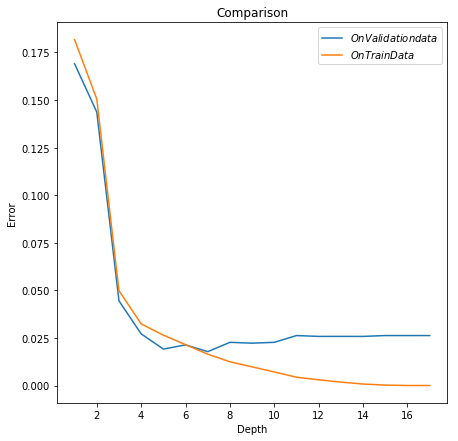

In [16]:
fig,axes=plt.subplots(figsize=(7,7))
axes.plot(xcoordinates,ycoordinates,label=r"$On Validation data$")
axes.plot(xtrain,ytrain,label=r"$On Train Data$")
legend=axes.legend(loc='best')
axes.set_title('Comparison')
plt.xlabel('Depth')
plt.ylabel('Error')


In [17]:
def count_node(root,depth):
    if depth==0:
        return 1
    if root.isLeaf==True:
        return 1
    x=1
    depth-=1
    for i in root.child.keys():
        x+=count_node(root.child[i],depth)
    return x

In [18]:
total_nodes=count_node(root,23)


In [19]:
depth_of_tree=depth(root)
xcoordinates1=[]
ycoordinates1=[]
xlabel1=[]
ylabel1=[]
# print depth_of_tree
depth_of_tree+=1
# print depth_of_tree
# node_dictionary={}
for i in range(1,depth_of_tree):
#     print i
    number=count_node(root,i)
    xcoordinates1.append(number)
    xlabel1.append(number)
#     print i,no_of_nodes_uptil_now
    y=calculate_error(validate,i)
    y1=calculate_error(train,i)
    ycoordinates1.append(y)
    ylabel1.append(y1)

Text(0,0.5,'Error')

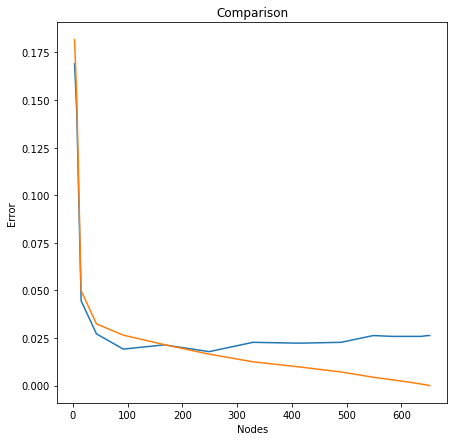

In [20]:
fig,axes=plt.subplots(figsize=(7,7))
axes.plot(xcoordinates1,ycoordinates1,label=r"$On Validation data$")
axes.plot(xlabel1,ylabel1,label=r"$On Train Data$")
axes.set_title('Comparison')
plt.xlabel('Nodes')
plt.ylabel('Error')

In [21]:
#if training data does not has something and validation do have..handle that case in classify(missing data) 
#merge all scattered codes
#sample.csv (done)
#report
#scikit learn
#q6